# A Location-based Recommender System for Restaurant Business Expansion
## IBM Data Science Professional Capstone Project
Junkang Gu – 2020<br>
jgu8@u.rochester.edu<br>
University of Rochester, NY<br>

# 1. Import libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from geopy.geocoders import GoogleV3

from numpy import linalg

import matplotlib.pyplot as plt

import sys
print("Libraries imported.")

Libraries imported.


## 1.2 APIs

In [2]:

geolocator = GoogleV3(api_key="")
from geopy.geocoders import Nominatim
geolocator2 = Nominatim(user_agent="Data")

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version


## 1.3 Public functions and variables

In [3]:
def getNearbyVenues(names, latitudes, longitudes, radius=100, LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Center Latitude', 
                  'Center Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [4]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

# 2. Data Preparation

## 2.1 Research subjects

In [5]:
#Existing store samples proven to be successful:
existing_stores_query = "Shake Shack in NYC"
sample_city = "New York City"
#Target City for expansion:
target_city_query = "Rochester"

## 2.2 Existing stores for sampling
### 2.2.1 Obtain the coordinates of the existing stores<br>

In [6]:
#Location list for samples
sample_loc_list = geolocator2.geocode(query=existing_stores_query, exactly_one=False)
sample_loc_list

[Location(Shake Shack, Broadway, Financial District, Manhattan, Manhattan Community Board 1, New York County, New York, 10038, United States of America, (40.7105601, -74.0090139, 0.0)),
 Location(Shake Shack, Broadway, Morningside Heights, Manhattan, Manhattan Community Board 9, New York County, New York, 10025, United States of America, (40.8079479, -73.9643022, 0.0)),
 Location(Shake Shack, Ring Road, Staten Island Mall, Staten Island, New York, Richmond County, New York, 10314-3903, United States of America, (40.5817907, -74.1676659, 0.0)),
 Location(Shake Shack, Terminal 4 Departures, Bayswater, New York, Queens County, New York, 11430, United States of America, (40.6380016, -73.781199, 0.0)),
 Location(Shake Shack, Richmond Terrace, Saint George, Staten Island, New York, Richmond County, New York, 10301, United States of America, (40.6437423, -74.0758746, 0.0)),
 Location(Shake Shack, Fulton Street, Downtown Brooklyn, New York, Brooklyn, Kings County, New York, 11201, United State

In [7]:
sample_loc_df = pd.DataFrame()
for x in sample_loc_list:
    new_row = {'name':existing_stores_query,'latitude':x.latitude, 'longitude':x.longitude}
    sample_loc_df = sample_loc_df.append(new_row, ignore_index=True)
sample_loc_df = sample_loc_df[['name','latitude','longitude']]
sample_loc_df.head()

,name,latitude,longitude
0,Shake Shack in NYC,40.710560,-74.009014
1,Shake Shack in NYC,40.807948,-73.964302
2,Shake Shack in NYC,40.581791,-74.167666
3,Shake Shack in NYC,40.638002,-73.781199
4,Shake Shack in NYC,40.643742,-74.075875


### 2.2.2 Venue analysis on existing stores

In [8]:
for attempt in range(10):
    try:
        sample_venues = getNearbyVenues(names=sample_loc_df['name'],
                                   latitudes=sample_loc_df['latitude'],
                                   longitudes=sample_loc_df['longitude']                              
                                  )
        break
    except:
        continue
sample_venues.head()

,Name,Center Latitude,Center Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Shake Shack in NYC,40.71056,-74.009014,Shake Shack,40.710703,-74.009024,Burger Joint
1,Shake Shack in NYC,40.71056,-74.009014,Anthropologie,40.710618,-74.009661,Women's Store
2,Shake Shack in NYC,40.71056,-74.009014,Chick-fil-A,40.710419,-74.008550,Fast Food Restaurant
3,Shake Shack in NYC,40.71056,-74.009014,The Assemblage John Street,40.710104,-74.008574,Coworking Space
4,Shake Shack in NYC,40.71056,-74.009014,Nobu Downtown,40.710532,-74.009593,Japanese Restaurant


### 2.2.3 Visualization of samples

In [9]:
sample_loc = geolocator.geocode(query=sample_city, exactly_one=True)
sample_loc

Location(New York, NY, USA, (40.7127753, -74.0059728, 0.0))

In [10]:
sample_latitude = sample_loc.latitude
sample_longitude = sample_loc.longitude

In [11]:
map_sample = folium.Map(location=[sample_latitude, sample_longitude], zoom_start=12)
for lat, lng, store in zip(sample_loc_df['latitude'],sample_loc_df['longitude'], sample_loc_df['name']):
    label = f'{store},{lat},{lng}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sample)  

map_sample

### 2.2.4 Process Venue data

In [12]:
# one hot encoding
sample_onehot = pd.get_dummies(sample_venues[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
sample_onehot['Name'] = sample_venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [sample_onehot.columns[-1]] + list(sample_onehot.columns[:-1])
sample_onehot = sample_onehot[fixed_columns]
sample_onehot.head()

,Name,Airport Lounge,BBQ Joint,Bakery,Bar,Basketball Stadium,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Coworking Space,Dessert Shop,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,French Restaurant,Gastropub,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Nightclub,Outlet Mall,Paper / Office Supplies Store,Pizza Place,Plaza,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tennis Stadium,Train Station,Vietnamese Restaurant,Women's Store
0,Shake Shack in NYC,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Shake Shack in NYC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Shake Shack in NYC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Shake Shack in NYC,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Shake Shack in NYC,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
#Take the mean of the frequency of occurrence of each category
sample_grouped = sample_onehot.groupby('Name').mean().reset_index()
sample_grouped.head()

,Name,Airport Lounge,BBQ Joint,Bakery,Bar,Basketball Stadium,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Coworking Space,Dessert Shop,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,French Restaurant,Gastropub,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Nightclub,Outlet Mall,Paper / Office Supplies Store,Pizza Place,Plaza,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tennis Stadium,Train Station,Vietnamese Restaurant,Women's Store
0,Shake Shack in NYC,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.138889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.027778,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889


## 2.3 Target city for potential expansion

### 2.3.1 Obtain the coordinate of the target city

In [14]:
#Coordinate of the target city
target_loc = geolocator.geocode(query=target_city_query, exactly_one=True)
target_loc

Location(Rochester, NY, USA, (43.15657789999999, -77.6088465, 0.0))

In [15]:
target_latitude = target_loc.latitude
target_longitude = target_loc.longitude

### 2.3.2 Obtain neighborhood information 

### Scrape neighborhood names from rocwiki

In [16]:
data = requests.get('https://rocwiki.org/Rochester_Neighborhoods').text
soup = BeautifulSoup(data, 'html.parser')
target_neighborhoods_df = pd.DataFrame()
alltables = soup.findAll("div", {"class": "wikitable"}) #get all tables on the page

t2_rows = alltables[1].find_all("tr") #get rows of the 2nd table
for cell in t2_rows:
    element = cell.find_all("a")
    if(len(element)>0):
        new_row = {'Neighborhood':element[0].text.rstrip('\n')}
        target_neighborhoods_df = target_neighborhoods_df.append(new_row, ignore_index=True)
        
t3_rows = alltables[2].find_all("tr") #get rows of the 3rd table
for cell in t3_rows:
    element = cell.find_all("a")
    if(len(element)>0):
        new_row = {'Neighborhood':element[0].text.rstrip('\n')}
        target_neighborhoods_df = target_neighborhoods_df.append(new_row, ignore_index=True)
        
target_neighborhoods_df.head()

,Neighborhood
0,Cascade District
1,Convention District
2,East End
3,Four Corners
4,Grove Place


In [17]:
for attempt in range(10):
    try:
        target_nbhd_df = pd.DataFrame()
        for nbhd in target_neighborhoods_df['Neighborhood']:
            loc = geolocator.geocode(query=f"{nbhd} rochester", exactly_one=True)
            new_row = {'Neighborhood':nbhd,'Latitude':loc.latitude, 'Longitude': loc.longitude}
            target_nbhd_df = target_nbhd_df.append(new_row, ignore_index=True)
        target_nbhd_df = target_nbhd_df[['Neighborhood','Latitude','Longitude']]
        break
    except:
        continue
target_nbhd_df.head()

,Neighborhood,Latitude,Longitude
0,Cascade District,43.155540,-77.619205
1,Convention District,43.156389,-77.609167
2,East End,43.154971,-77.594786
3,Four Corners,43.155428,-77.612713
4,Grove Place,43.159181,-77.599871


In [18]:
print(target_nbhd_df.shape)
target_nbhd_df.drop_duplicates(subset ="Neighborhood", keep = False, inplace = True)
print(target_nbhd_df.shape)

(64, 3)
(62, 3)


### 2.3.3 Visualization of target neighborhoods

In [19]:
map_target = folium.Map(location=[target_latitude, target_longitude], zoom_start=13)
for lat, lng, nbhd in zip(target_nbhd_df['Latitude'],target_nbhd_df['Longitude'], target_nbhd_df['Neighborhood']):
    label = f'{nbhd},{lat},{lng}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_target)  

map_target

### 2.3.4 Obtain venue data of target city

In [20]:
for attempt in range(10):
    try:
        target_nbhd_venues = getNearbyVenues(names=target_nbhd_df['Neighborhood'],
                                   latitudes=target_nbhd_df['Latitude'],
                                   longitudes=target_nbhd_df['Longitude']                              
                                  )
        break
    except:
        continue
target_nbhd_venues.head()

,Name,Center Latitude,Center Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Convention District,43.156389,-77.609167,Morton's The Steakhouse,43.156566,-77.608455,Steakhouse
1,Convention District,43.156389,-77.609167,Rochester Riverside Hotel,43.156826,-77.609954,Hotel
2,Convention District,43.156389,-77.609167,Starbucks,43.156616,-77.608549,Coffee Shop
3,Convention District,43.156389,-77.609167,Hyatt Regency Rochester,43.156469,-77.608561,Hotel
4,Convention District,43.156389,-77.609167,Hyatt Focus Lounge,43.156549,-77.608646,Bar


### 2.3.5 Process venue data of target city

In [21]:
# one hot encoding
target_onehot = pd.get_dummies(target_nbhd_venues[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
target_onehot['Name'] = target_nbhd_venues['Name'] 

# move name column to the first column
fixed_columns = [target_onehot.columns[-1]] + list(target_onehot.columns[:-1])
target_onehot = target_onehot[fixed_columns]
target_onehot.head()

,Name,American Restaurant,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Boutique,Brewery,Burger Joint,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Dance Studio,Diner,Dog Run,Donut Shop,Fried Chicken Joint,Frozen Yogurt Shop,Gym,Hawaiian Restaurant,Historic Site,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Lawyer,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Museum,Park,Pet Store,Pharmacy,Pizza Place,Pub,Recreation Center,Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Smoke Shop,Steakhouse,Theater,Thrift / Vintage Store,Video Store,Wine Bar
0,Convention District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Convention District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Convention District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Convention District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Convention District,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
target_grouped = target_onehot.groupby('Name').mean().reset_index()
target_grouped

,Name,American Restaurant,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Boutique,Brewery,Burger Joint,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Dance Studio,Diner,Dog Run,Donut Shop,Fried Chicken Joint,Frozen Yogurt Shop,Gym,Hawaiian Restaurant,Historic Site,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Lawyer,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Museum,Park,Pet Store,Pharmacy,Pizza Place,Pub,Recreation Center,Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Smoke Shop,Steakhouse,Theater,Thrift / Vintage Store,Video Store,Wine Bar
0,ABC Streets Neighborhood,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.4,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.00,0.000000,0.00
1,Bull's Head,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
2,Changing of the Scenes,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,1.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
3,College Town,0.000000,0.0,0.000000,0.076923,0.076923,0.000000,0.000000,0.00,0.00,0.076923,0.0,0.076923,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.076923,0.00,0.000000,0.0,0.0,0.0,0.076923,0.076923,0.0,0.076923,0.0,0.00,0.076923,0.000000,0.0,0.0,0.00,0.076923,0.000000,0.00,0.0,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.00,0.00,0.000000,0.00
4,Convention District,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.4,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.00,0.000000,0.00
5,Corn Hill,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
6,Culver University East,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.333333,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.333333,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.333333,0.00
7,Culver-Merchants,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.25,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.250000,0.000000,0.25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
8,East Avenue Historic District,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.00

# 3. Data Cleaning

## 3.1 Examine the data

In [23]:
sample_grouped

,Name,Airport Lounge,BBQ Joint,Bakery,Bar,Basketball Stadium,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Coworking Space,Dessert Shop,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,French Restaurant,Gastropub,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Nightclub,Outlet Mall,Paper / Office Supplies Store,Pizza Place,Plaza,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tennis Stadium,Train Station,Vietnamese Restaurant,Women's Store
0,Shake Shack in NYC,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.138889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.027778,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889


In [24]:
target_grouped

,Name,American Restaurant,Arts & Crafts Store,Asian Restaurant,Bakery,Bank,Bar,Beer Bar,Boutique,Brewery,Burger Joint,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Dance Studio,Diner,Dog Run,Donut Shop,Fried Chicken Joint,Frozen Yogurt Shop,Gym,Hawaiian Restaurant,Historic Site,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Lawyer,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Museum,Park,Pet Store,Pharmacy,Pizza Place,Pub,Recreation Center,Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Smoke Shop,Steakhouse,Theater,Thrift / Vintage Store,Video Store,Wine Bar
0,ABC Streets Neighborhood,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.4,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.00,0.000000,0.00
1,Bull's Head,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
2,Changing of the Scenes,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,1.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
3,College Town,0.000000,0.0,0.000000,0.076923,0.076923,0.000000,0.000000,0.00,0.00,0.076923,0.0,0.076923,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.076923,0.00,0.000000,0.0,0.0,0.0,0.076923,0.076923,0.0,0.076923,0.0,0.00,0.076923,0.000000,0.0,0.0,0.00,0.076923,0.000000,0.00,0.0,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.00,0.00,0.000000,0.00
4,Convention District,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.4,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.00,0.00,0.000000,0.00
5,Corn Hill,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
6,Culver University East,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.333333,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.333333,0.0,0.0,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.333333,0.00
7,Culver-Merchants,0.000000,0.0,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.25,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00,0.250000,0.000000,0.25,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00
8,East Avenue Historic District,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.0,0.000000,0.00,0.00,0.000000,0.000000,0.00

## 3.2 Pad missing columns with zero

In [25]:
lst1 = list(sample_grouped)
lst2 = list(target_grouped)
col_for_lst2 = list(set(lst1) - set (lst2))
for x in col_for_lst2:
    target_grouped[x] = 0
col_for_lst1 = list(set(lst2) - set (lst1))
for x in col_for_lst1:
    sample_grouped[x] = 0
target_grouped = target_grouped[list(sample_grouped)]

In [26]:
sample_grouped.head()

,Name,Airport Lounge,BBQ Joint,Bakery,Bar,Basketball Stadium,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Coworking Space,Dessert Shop,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,French Restaurant,Gastropub,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Nightclub,Outlet Mall,Paper / Office Supplies Store,Pizza Place,Plaza,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tennis Stadium,Train Station,Vietnamese Restaurant,Women's Store,Salon / Barbershop,Boutique,Historic Site,Park,Dance Studio,Business Service,Hot Dog Joint,Wine Bar,Video Store,Intersection,Dog Run,Thrift / Vintage Store,Lawyer,Convenience Store,Fried Chicken Joint,Pet Store,Brewery,Arts & Crafts Store,Pub,American Restaurant,Recreation Center,Chinese Restaurant,Frozen Yogurt Shop,Mobile Phone Shop,Bank,Caribbean Restaurant,Indian Restaurant,Smoke Shop,Diner,Museum,Hawaiian Restaurant,Asian Restaurant,Theater,Beer Bar,Pharmacy
0,Shake Shack in NYC,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.138889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.041667,0.013889,0.013889,0.013889,0.027778,0.013889,0.013889,0.027778,0.013889,0.027778,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
sample_grouped.shape

(1, 88)

In [28]:
target_grouped.head()

,Name,Airport Lounge,BBQ Joint,Bakery,Bar,Basketball Stadium,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Coworking Space,Dessert Shop,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,French Restaurant,Gastropub,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Nightclub,Outlet Mall,Paper / Office Supplies Store,Pizza Place,Plaza,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tennis Stadium,Train Station,Vietnamese Restaurant,Women's Store,Salon / Barbershop,Boutique,Historic Site,Park,Dance Studio,Business Service,Hot Dog Joint,Wine Bar,Video Store,Intersection,Dog Run,Thrift / Vintage Store,Lawyer,Convenience Store,Fried Chicken Joint,Pet Store,Brewery,Arts & Crafts Store,Pub,American Restaurant,Recreation Center,Chinese Restaurant,Frozen Yogurt Shop,Mobile Phone Shop,Bank,Caribbean Restaurant,Indian Restaurant,Smoke Shop,Diner,Museum,Hawaiian Restaurant,Asian Restaurant,Theater,Beer Bar,Pharmacy
0,ABC Streets Neighborhood,0,0,0.000000,0.2,0,0,0.000000,0.000000,0,0.0,0.2,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.4,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.200000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Bull's Head,0,0,0.000000,0.0,0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.000000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,Changing of the Scenes,0,0,0.000000,0.0,0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.000000,0,0,0,0,0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,College Town,0,0,0.076923,0.0,0,0,0.076923,0.076923,0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.076923,0.076923,0,0,0.0,0.076923,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.076923,0,0.076923,0,0,0,0,0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.076923,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923
4,Convention District,0,0,0.000000,0.2,0,0,0.000000,0.000000,0,0.0,0.2,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.4,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.200000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [29]:
target_grouped.shape

(29, 88)

# 4. K-means Clustering

## 4.1 Identify the optimal K value

In [30]:
k_clustering = target_grouped.drop('Name',1)

### 4.1.1 The elbow method -  find the "elbow point"

In [31]:
kmax = 20
errors = []
for k in range(1, kmax+1):
    error = 0
    kmeans = KMeans(n_clusters=k, random_state=0).fit(k_clustering)
    centroids = kmeans.cluster_centers_
    label = kmeans.labels_
    for i in range(0, len(k_clustering)):
        groupid = label[i]
        centroid = centroids[groupid]
        dist = linalg.norm(k_clustering.iloc[i].to_numpy() - centroid)
        error += dist
    errors.append(error/len(k_clustering))
print(errors)

[0.6362518815118066, 0.5718371565848893, 0.4809229567040843, 0.4464092323416483, 0.41185475193859084, 0.37724343950909756, 0.3430039498545275, 0.3077458030797885, 0.2732787368337994, 0.23877876551860308, 0.2140433896480592, 0.19371707838811664, 0.1728557769809712, 0.14034512037469318, 0.12250473047990232, 0.10575150889349393, 0.08993946968013365, 0.07320290821439221, 0.05734393191318089, 0.04162978879562905]


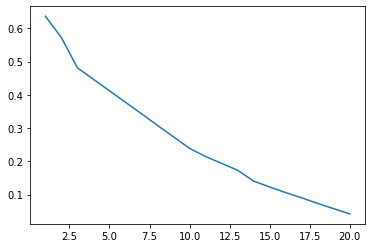

In [32]:
x_axis = range(1,kmax+1)
plt.plot(x_axis, errors)
plt.show()

### 4.1.2 The Silhouette Method - find the global maximum - use if the elbow method fails

In [33]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters=k, random_state=0).fit(k_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(k_clustering, labels, metric = 'euclidean'))

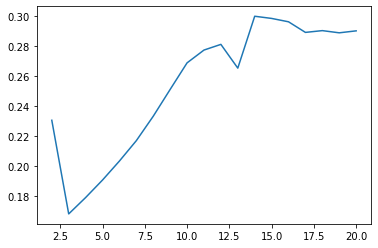

In [34]:
x_axis = range(2,kmax+1)
plt.plot(x_axis, sil)
plt.show()

## 4.2 Train with the optimal K value

In [35]:
kclusters = 14
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(k_clustering)
kmeans.labels_

array([ 1,  5,  0,  4,  1, 10, 13,  4,  9,  4,  4,  4,  4,  1,  4,  1,  2,
        2, 11,  4,  7,  4,  1,  8,  6,  4,  3, 12,  1])

## 4.3 Clustering result

In [36]:
# add clustering labels
target_grouped.insert(0, 'Cluster_Labels', kmeans.labels_)

target_grouped.head()

,Cluster_Labels,Name,Airport Lounge,BBQ Joint,Bakery,Bar,Basketball Stadium,Bubble Tea Shop,Burger Joint,Café,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Cosmetics Shop,Coworking Space,Dessert Shop,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Food Truck,French Restaurant,Gastropub,Gym,Gym / Fitness Center,Hotel,Ice Cream Shop,Italian Restaurant,Japanese Restaurant,Lounge,Mediterranean Restaurant,Mexican Restaurant,Movie Theater,Nightclub,Outlet Mall,Paper / Office Supplies Store,Pizza Place,Plaza,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Shipping Store,Shopping Mall,Sporting Goods Shop,Steakhouse,Tapas Restaurant,Tennis Stadium,Train Station,Vietnamese Restaurant,Women's Store,Salon / Barbershop,Boutique,Historic Site,Park,Dance Studio,Business Service,Hot Dog Joint,Wine Bar,Video Store,Intersection,Dog Run,Thrift / Vintage Store,Lawyer,Convenience Store,Fried Chicken Joint,Pet Store,Brewery,Arts & Crafts Store,Pub,American Restaurant,Recreation Center,Chinese Restaurant,Frozen Yogurt Shop,Mobile Phone Shop,Bank,Caribbean Restaurant,Indian Restaurant,Smoke Shop,Diner,Museum,Hawaiian Restaurant,Asian Restaurant,Theater,Beer Bar,Pharmacy
0,1,ABC Streets Neighborhood,0,0,0.000000,0.2,0,0,0.000000,0.000000,0,0.0,0.2,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.4,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.200000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,5,Bull's Head,0,0,0.000000,0.0,0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.000000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0,Changing of the Scenes,0,0,0.000000,0.0,0,0,0.000000,0.000000,0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.000000,0,0,0,0,0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,College Town,0,0,0.076923,0.0,0,0,0.076923,0.076923,0,0.0,0.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.076923,0.076923,0,0,0.0,0.076923,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.076923,0,0.076923,0,0,0,0,0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.076923,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923
4,1,Convention District,0,0,0.000000,0.2,0,0,0.000000,0.000000,0,0.0,0.2,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0.4,0.000000,0.000000,0,0,0.0,0.000000,0,0,0,0,0.0,0,0.0,0,0.0,0,0,0,0.000000,0,0.200000,0,0,0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [37]:
target_grouped = pd.merge(target_grouped, target_nbhd_df, how='left', left_on=['Name'], right_on=['Neighborhood'])
target_grouped = target_grouped[['Cluster_Labels','Name','Latitude','Longitude']]

In [38]:
target_grouped.head()

,Cluster_Labels,Name,Latitude,Longitude
0,1,ABC Streets Neighborhood,43.156578,-77.608846
1,5,Bull's Head,43.148933,-77.635535
2,0,Changing of the Scenes,43.147237,-77.621773
3,4,College Town,43.123889,-77.618333
4,1,Convention District,43.156389,-77.609167


## 4.4 Clusters Visualization

In [39]:
map_group = folium.Map(location=[target_latitude, target_longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for lat, lng, nbhd, gp in zip(target_grouped['Latitude'],target_grouped['Longitude'], target_grouped['Name'], target_grouped['Cluster_Labels']):
    label = f'{nbhd},{lat},{lng},Group{gp}'
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color=rainbow[gp-1],
        fill=True,
        fill_color=rainbow[gp-1],
        fill_opacity=0.2,
        parse_html=False).add_to(map_group)  

map_group

# 5. Recommendation

## 5.1 Process the data

In [40]:
target_centroids = kmeans.cluster_centers_
sample_group = sample_grouped.drop(["Name"], 1)
kmeans2 = KMeans(n_clusters=1).fit(sample_group)
sample_centroid = kmeans2.cluster_centers_[0]

In [41]:
min_dist = sys.maxsize
index = 0
for i in range(len(target_centroids)):
    d = linalg.norm(target_centroids[i] - sample_centroid)
    if min_dist > d:
        index = i
        min_dist = d
print(f'Group {index} is the closest cluster to the sample centroid.')

Group 4 is the closest cluster to the sample centroid.


In [42]:
group_rank = {}
for i in range(len(target_centroids)):
    d = linalg.norm(target_centroids[i] - sample_centroid)
    group_rank[i] = d
    
sort_orders = sorted(group_rank.items(), key=lambda x: x[1], reverse=False)
rank_list = []
for i in sort_orders:
    print(i[0], i[1])
    rank_list.append(i[0])

4 0.21682063561003495
1 0.510597568093709
13 0.6079463507844247
6 0.7323014625813371
8 0.7323014625813371
12 0.7323014625813371
0 1.0179712334338165
2 1.0179712334338165
3 1.0179712334338165
5 1.0179712334338165
7 1.0179712334338165
9 1.0179712334338165
10 1.0179712334338165
11 1.0179712334338165


In [43]:
top25 = int(len(rank_list)/4)
top50 = int(len(rank_list)/2)

recommendation = {}
i = 0
for x in rank_list:
    if i == 0:
        recommendation[x] = "Top Recommended"
    elif i < top25:
        recommendation[x] = "Strongly Recommended"
    elif i < top50:
        recommendation[x] = "Weakly Recommended"
    else:
        recommendation[x] = "Not Recommended"
    i += 1
recommendation

{4: 'Top Recommended',
 1: 'Strongly Recommended',
 13: 'Strongly Recommended',
 6: 'Weakly Recommended',
 8: 'Weakly Recommended',
 12: 'Weakly Recommended',
 0: 'Weakly Recommended',
 2: 'Not Recommended',
 3: 'Not Recommended',
 5: 'Not Recommended',
 7: 'Not Recommended',
 9: 'Not Recommended',
 10: 'Not Recommended',
 11: 'Not Recommended'}

## 5.2 Recommendation result

In [44]:
rec = []
for lb, name in zip(target_grouped['Cluster_Labels'],target_grouped['Name']):
    rec.append(recommendation[lb])
target_grouped['Recommendation'] = rec
target_grouped.head()

,Cluster_Labels,Name,Latitude,Longitude,Recommendation
0,1,ABC Streets Neighborhood,43.156578,-77.608846,Strongly Recommended
1,5,Bull's Head,43.148933,-77.635535,Not Recommended
2,0,Changing of the Scenes,43.147237,-77.621773,Weakly Recommended
3,4,College Town,43.123889,-77.618333,Top Recommended
4,1,Convention District,43.156389,-77.609167,Strongly Recommended


## 5.3 Recommendation visualization

In [45]:
map_rec = folium.Map(location=[target_latitude, target_longitude], zoom_start=13)
for lat, lng, nbhd, rmd in zip(target_grouped['Latitude'],target_grouped['Longitude'], target_grouped['Name'], target_grouped['Recommendation']):
    label = f'{nbhd},{rmd},{lat},{lng}'
    label = folium.Popup(label, parse_html=True)
    if rmd == 'Top Recommended':
        fo=0.9
    elif rmd == 'Strongly Recommended':
        fo=0.5
    elif rmd == 'Weakly Recommended':
        fo=0.2
    else:
        fo=0.1
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='grey',
        fill=True,
        fill_color='#3186cc',
        fill_opacity = fo,
        parse_html=False).add_to(map_rec)  

map_rec

# 6. Observation

From the "Shake Shack in Rochester" example, we can observe that the recommended places are mostly clustered in the downtown of Rochester, as well as a few other places, such as the College Town and Marketplace, outside the downtown. This is because according to the venue data we obtained, these places are the most similar to the neighborhoods of existing Shake Shack stores in NYC, based on the analysis of the surrounding environment. If Shake Shack decided to expand its business to Rochester, the top-recommended placed above would likely to be the potential locations for new Shake Shack stores. This matches our hypothesis, as Shake Shack commonly sells in busy, middle-to-upper class, urban areas, and the downtown and college town are the places in Rochester most likely to fit in that category.